Scratch notebook to work on power calc functions

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import style
import importlib
import matplotlib.ticker as mtick

from scipy.interpolate import make_interp_spline

In [2]:
pd.options.display.max_columns=500
pd.options.display.max_colwidth=500
pd.options.display.max_rows=500

In [132]:
style.use('fivethirtyeight')

In [4]:
# sys.path.append('../../scratch_work/ab_testing_utils/')
sys.path.append('../../../ab_testing_utils/')

In [5]:
import conversion_rate_utils

In [6]:
def compute_sample_size(p0, mde, alpha=0.05, beta=0.2, tails="Two"):
    """
    Returns the sample size for a two-tailed AB test comparing conversion
    rates.
    The sample size equation is for binomial distributions only.
    Parameters
    ----------
    p0 : float
        Baseline conversion rate
    mde : float or int
        Minimum detectable effect. This is the 'sensitivity' of the test or
        the relative difference in conversion rates that you want to be able
        to detect.
    alpha : float
        The chances of a Type I error. Tests are normally run to a 95%
        significance meaning an alpha of 1 - 0.95 = 0.05. Default = 0.05.
    beta : float
        The chances of a Type II error. For sample sizing, a beta of 0.2 is
        acceptable and provides the test with 80% statistical power as is
        standard.
    tails : str
        One or two tails to specify what type of hypothesis test this is.
    Returns
    -------
    Minimum number of observations required per variant.
    """

    # Conditional alpha value based on whether one or two tail test
    if tails == "Two":
        computed_alpha = alpha / 2
    else:
        computed_alpha = alpha

    p1 = p0 * (1 + mde)
    N = (
        (stats.norm.ppf(1 - computed_alpha) + stats.norm.ppf(1 - beta)) ** 2
        * (p0 * (1 - p0) + p1 * (1 - p1))
        / ((p0 - p1) ** 2)
    )
    return int(N)

In [7]:
compute_sample_size(0.1, 0.05)

57759

In [8]:
df = pd.DataFrame()

In [9]:
test_my_code = conversion_rate_utils.ConversionExperiment(df=df)

In [10]:
test_my_code.calc_sample_size(power=0.8, alpha=0.05, relative_minimum_detectable_effect_size=0.05, baseline_conversion_rate=0.1)

56512

In [11]:
np.sin(np.arcsin(np.sqrt(0.1)) - 0.0117394/2)**2

0.09650582327777069

In [12]:
0.1 - 0.09650582327777069

0.0034941767222293196

In [13]:
# So my code seems to differ a bit.  The code above agrees mostly with pwr.2p.test(h=ES.h(p1=0.1, p2=0.105), sig.level=0.05, power=0.8, alternative="two.sided")
# Why? 
# mine is computing N as 2 * (sigma_squared * (z_power + z_alpha) ** 2) / delta**2
# Is this different than above? Let's walk through it and see where we diverge:

In [14]:
# My calc:
sigma_squared = 0.1 * (1 - 0.1)
delta_ = 0.1*0.05

In [15]:
sigma_squared

0.09000000000000001

In [16]:
delta_

0.005000000000000001

In [17]:
z_alpha = stats.norm.ppf(1 - (0.05)/2)
z_power = stats.norm.ppf(0.8)

In [18]:
z_alpha

1.959963984540054

In [19]:
z_power

0.8416212335729143

In [20]:
2 * (sigma_squared * (z_alpha + z_power) ** 2) / (delta_)**2

56511.93408731341

In [21]:
# Other calc:
# p1 = p0 * (1 + mde)
# N = (
#     (stats.norm.ppf(1 - computed_alpha) + stats.norm.ppf(1 - beta)) ** 2
#     * (p0 * (1 - p0) + p1 * (1 - p1))
#     / ((p0 - p1) ** 2)
# )
p1 = 0.1 * (1 + 0.05)

In [22]:
p1

0.10500000000000001

In [23]:
# This should be the same as my: (correct)
0.1 + delta_

0.10500000000000001

In [24]:
(stats.norm.ppf(1 - 0.05/2) + stats.norm.ppf(0.8)) ** 2

7.848879734349088

In [25]:
# Compare to my intermediate term:
(z_alpha + z_power) ** 2

7.848879734349088

In [26]:
# The same

In [27]:
# The calc above then gets multiplied by:
0.1 * (1 - 0.1) + p1 * (1 - p1)

0.18397500000000003

In [28]:
2*sigma_squared

0.18000000000000002

In [29]:
# So this is slightly higher than 2 times sigma squared? Why? Is this the difference?
# The result is divided by:
(0.1 - p1) ** 2

2.5000000000000045e-05

In [30]:
delta_**2

2.500000000000001e-05

In [31]:
# which is the same as my delta_**2 term, so the only difference arises from the 2*sigma_squared term.  I think this is possibly an approximation on my part

In [32]:
# Yeah, it's probably because of this:
int(np.round(16 * sigma_squared /delta_**2))

57600

In [33]:
# Let's try this.  Say p1 = 0.5, p2 = 0.55
# Then relative_mde = (0.55 - 0.5)/0.5 = 0.1
# My calc gives:
test_my_code.calc_sample_size(power=0.999, alpha=0.001, relative_minimum_detectable_effect_size=0.1, baseline_conversion_rate=0.5)

8143

In [34]:
compute_sample_size(0.5, 0.1, alpha=0.001, beta=1-0.999)

8102

In [35]:
# roboto = {"fontname": "Roboto", "size": "11"}
# roboto_light = {"fontname": "Roboto", "size": "10", "weight": "light"}
# roboto_title = {"fontname": "Roboto", "size": "12", "weight": "bold"}
# roboto_small = {"fontname": "Roboto", "size": "7.5", "weight": "light"}

# font = {"family": "sans-serif", "sans-serif": "roboto", "size": 11}

# plt.rc("font", **font)

In [36]:
def round_and_int_convert_columns(df_, col_name):
    # We actually need to be a bit careful here.  Experimental runtimes should be conservative: biased upwards, where as expected additional lifts should be biased downwards
    if col_name in ['monthly_additional_conversions_upper', 'monthly_additional_conversions_lower']:
        df_[col_name] = np.round(df_[col_name])
        df_[col_name] = df_[col_name].astype(int)
    else:
        df_[col_name] = np.ceil(df_[col_name])
        df_[col_name] = df_[col_name].astype(int)
    return df_

In [636]:
# Ok so this is fine. I'm going to stick with my code.  I have a better theoretical justification for why this is sensible. 
def create_mde_table(monthly_num_obs, baseline_conversion_rate, exp_params, n_variants=2, alpha=0.05, power=0.8):
    mde_range = np.arange(0.001, 2.001, 0.001)
    
    sample_sizes = [exp_params.calc_sample_size(power=power, 
                                                  alpha=alpha, 
                                                  relative_minimum_detectable_effect_size=mde, 
                                                  baseline_conversion_rate=baseline_conversion_rate) * n_variants for mde in mde_range]
    new_conversion_rates_upper = [baseline_conversion_rate + exp_params.calc_delta(baseline_conversion_rate=baseline_conversion_rate, 
                                                                              relative_minimum_detectable_effect_size=mde) for mde in mde_range]
    new_conversion_rates_lower = [baseline_conversion_rate - exp_params.calc_delta(baseline_conversion_rate=baseline_conversion_rate, 
                                                                          relative_minimum_detectable_effect_size=mde) for mde in mde_range]
    df_ = pd.DataFrame()
    df_['mde'] = mde_range
    df_['new_conversion_rate_upper_bound'] = new_conversion_rates_upper
    df_['new_conversion_rate_lower_bound'] = new_conversion_rates_lower
    df_['total_sample_size'] = sample_sizes
    df_['sample_size_per_variant'] = np.array(sample_sizes) / n_variants
    df_['days'] = df_['total_sample_size'] / (monthly_num_obs / 30)
    df_['weeks'] = df_['days'] / 7
    df_['monthly_additional_conversions_upper'] = (df_['new_conversion_rate_upper_bound'] * monthly_num_obs) - (baseline_conversion_rate * monthly_num_obs)
    df_['monthly_additional_conversions_lower'] = (df_['new_conversion_rate_lower_bound'] * monthly_num_obs) - (baseline_conversion_rate * monthly_num_obs)
    
    for col_ in ['total_sample_size', 'sample_size_per_variant', 'days', 'weeks', 'monthly_additional_conversions_upper', 'monthly_additional_conversions_lower']:
        df_ = round_and_int_convert_columns(df_=df_, col_name=col_)
    
    return df_

In [121]:
# I'll also want a version to explore options around effect size and variations in power/significance level

In [637]:
exp_params = conversion_rate_utils.ConversionExperiment(df=pd.DataFrame(), post_hoc=False, is_experiment_data=False)

In [639]:
df_mde = create_mde_table(monthly_num_obs=500000, baseline_conversion_rate=0.1, exp_params=exp_params, n_variants=2, alpha=0.05, power=0.8)
# mde_ranges, sample_sizes, new_conversion_rates = create_mde_table(monthly_num_obs=5000, baseline_conversion_rate=0.1, n_variants=2, alpha=0.05, power=0.8)

In [640]:
df_mde.loc[df_mde['mde'] == 0.19]

,mde,new_conversion_rate_upper_bound,new_conversion_rate_lower_bound,total_sample_size,sample_size_per_variant,days,weeks,monthly_additional_conversions_upper,monthly_additional_conversions_lower
189,0.19,0.119,0.081,7828,3914,1,1,9500,-9500


In [641]:
compute_sample_size(p0=0.1, mde=0.5)

682

In [642]:
# Compare to evan miller's code:
# delta is the same
# t_alpha2 is the same as your z_alpha
# t_bets is the same as your z_beta
# sd1 = sqrt(2 * baseline * (1 - baseline))
# sd2 = sqrt(baseline * (1 - baseline) + (baseline + delta) * (1 - baseline - delta))
# then n = (t_alpha2 * sd1 + t_beta * sd2) * (t_alpha2 * sd1 + t_beta * sd2) / delta**2
# So the difference is in the numerator...yeah, this is just a difference in the approximation used
# EV seems to be using a calculation based explicity on comparing two t-distributions.
# We've built an approximation where the underlying distribution is assumed to be normal, and that the variance under the null
# and alternate hypotheses are equal.  This isn't strictly true, but for a large enough sample size, the central limit theorem 
# should apply and the two calculations will agree.  The point is that, while the exact sample size may vary between methods,
# the analyses are consistent within themselves for both frameworks. Also, the overall weekly runtime should not be drastically
# effected.  It might make sense to estimate the run time in days and round to the nearest week for a more conservative estimate

In [643]:
def y_format(x, pos):
    
    return f"{int(x):,}"

In [644]:
def plot_mde_marker(df, weeks, days, ax):
    
    # I think I need to fix this up a bit
    # days = weeks * 7
    # ax.axhline(y=days, linestyle='--', xmax=(df[df['weeks'] <= weeks]['mde'].min() - ax.get_xlim()[0]) / ax.get_xlim()[1] - 0.005)
    ax.axhline(y=days, linestyle='--', xmax=(df[df['days'] <= days]['mde'].min() - ax.get_xlim()[0]) / ax.get_xlim()[1] - 0.005)
    
    if weeks > 1:
        week_text = 'weeks'
    else:
        week_text = 'week'
        
    ax.text(ax.get_xlim()[0], days+1, f"{weeks} {week_text}", horizontalalignment='left')
    
    # try:
    # is_less = df['weeks'] <= weeks
    # print(df[is_less])
    # mde_text = "MDE = {0}%".format(np.round(df[is_less]['mde'].min()*100, 2))
    mde_text = "MDE = {0}%:\nConversion rates between {1}% and {2}% will not be distinguishable from baseline".format(np.round(df[df['weeks'] == weeks]['mde'].min()*100, 3), 
                                                                                                                       np.round(df[df['weeks'] == weeks]['new_conversion_rate_lower_bound'].min()*100, 3), 
                                                                                                                       np.round(df[df['weeks'] == weeks]['new_conversion_rate_upper_bound'].min()*100, 3))
    # mde_text = "MDE = {0}%, Range of extra monthly conversions: {1} - {2}".format(np.round(df[is_less]['mde'].min(), 2)*100, df[is_less]['monthly_additional_conversions_upper'].min(), df[is_less]['monthly_additional_conversions_lower'].min())
    # except KeyError:
    #     mde_text = "MDE = {0}%".format(np.round(df[is_less]['mde'].min()*100, 2))
    
    ax.text(df[df['weeks'] <= weeks]['mde'].min() * 1.05, days - 0.5, mde_text, horizontalalignment='left')
    # ax.text(df[df['days'] <= days]['mde'].min() * 1.05, days - 0.5, mde_text, horizontalalignment='left')
    # ax.text((df[df['days'] <= days]['mde'].min() - ax.get_xlim()[0]) / ax.get_xlim()[1] - 0.005, days - 0.5, mde_text, horizontalalignment='left')

In [645]:
def make_mde_plot(df_, min_weeks, max_weeks):
    fig, ax = plt.subplots(figsize=(12, 8))
    df_temp = df_.copy()
    
    # df_temp = df_[['mde', 'days', 'weeks']].groupby('weeks', as_index=False).agg({'mde': 'max', 'days': 'max'})
    # This should remove the necessity of calculating all these mins below...
    df_temp = df_temp[['mde', 'days', 'weeks', 'new_conversion_rate_upper_bound', 'new_conversion_rate_lower_bound']].loc[(df_temp.groupby('weeks')['days'].idxmax())]
    
    ax.plot("mde", 
            "days", 
            data=df_temp.loc[(df_temp['weeks'] >= min_weeks) & (df_temp['weeks'] <= max_weeks)], 
            linewidth=2, 
            solid_capstyle="round", 
            linestyle='--', 
            marker='o', 
            color='b')
    
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(y_format))
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    ax.set_xlabel('Minimum detectable effect size')
    ax.set_ylabel('')
    
    # Set limit to reasonable amount of time
    if ax.get_ylim()[1] > 60:
        ax.set_ylim([0, 7 * max_weeks * 1.2])

    # Set x-lim
    x_limit = df_temp[df_temp["weeks"] <= min_weeks]["mde"].min() * 1.2
    x_min = df_temp[df_temp['weeks'] == max_weeks]['mde'].min() 
    x_min = x_min - 0.1*x_min
    ax.set_xlim([x_min, x_limit])
    
    for weeks in range(min_weeks, max_weeks + 1):
        days_ = df_temp.query('weeks == {0}'.format(weeks))['days'].min()
        plot_mde_marker(df=df_temp, weeks=weeks, days=days_, ax=ax)
        
    ax.set_title('Experiment run times by minimum detectable effect size', fontsize=20)
    
    # We don't need the y-axis here
    ax.axes.get_yaxis().set_visible(False)
    
    ax.yaxis.grid(True)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

In [626]:
# yeah this doesn't work for shit
# spl = make_interp_spline(sorted(df_mde['days'].values, reverse=True), sorted(df_mde['mde'].values, reverse=True), k=3)
# xnew = np.linspace(df_mde['days'].min(), df_mde['days'].max(), 300)
# smooth = spl(xnew)
# df_temp = df_mde.copy()
# df_temp['xnew'] = xnew
# df_temp['smooth'] = smooth

In [627]:
# make_interp_spline(sorted(df_mde['days'].values, reverse=True), sorted(df_mde['mde'].values, reverse=True), k=3)

In [628]:
# df_mde['days'].values

In [629]:
# Right, we'll need to implement a week number cap.  The lower limit should be 2 weeks.  Upper limit, 30?
df_mde

,mde,new_conversion_rate_upper_bound,new_conversion_rate_lower_bound,total_sample_size,sample_size_per_variant,days,weeks,monthly_additional_conversions_upper,monthly_additional_conversions_lower
0,0.001,0.1001,0.0999,282559670,141279835,16954,2422,50,-50
1,0.002,0.1002,0.0998,70639918,35319959,4239,606,100,-100
2,0.003,0.1003,0.0997,31395518,15697759,1884,270,150,-150
3,0.004,0.1004,0.0996,17659980,8829990,1060,152,200,-200
4,0.005,0.1005,0.0995,11302386,5651193,679,97,250,-250
...,...,...,...,...,...,...,...,...,...
1995,1.996,0.2996,-0.0996,70,35,1,1,99800,-99800
1996,1.997,0.2997,-0.0997,70,35,1,1,99850,-99850
1997,1.998,0.2998,-0.0998,70,35,1,1,99900,-99900
1998,1.999,0.2999,-0.0999,70,35,1,1,99950,-99950


In [630]:
df_mde.query("weeks == 10")

,mde,new_conversion_rate_upper_bound,new_conversion_rate_lower_bound,total_sample_size,sample_size_per_variant,days,weeks,monthly_additional_conversions_upper,monthly_additional_conversions_lower
15,0.016,0.1016,0.0984,1103748,551874,67,10,800,-800


In [646]:
df_mde.query("weeks == 10")

,mde,new_conversion_rate_upper_bound,new_conversion_rate_lower_bound,total_sample_size,sample_size_per_variant,days,weeks,monthly_additional_conversions_upper,monthly_additional_conversions_lower
15,0.016,0.1016,0.0984,1103748,551874,67,10,800,-800


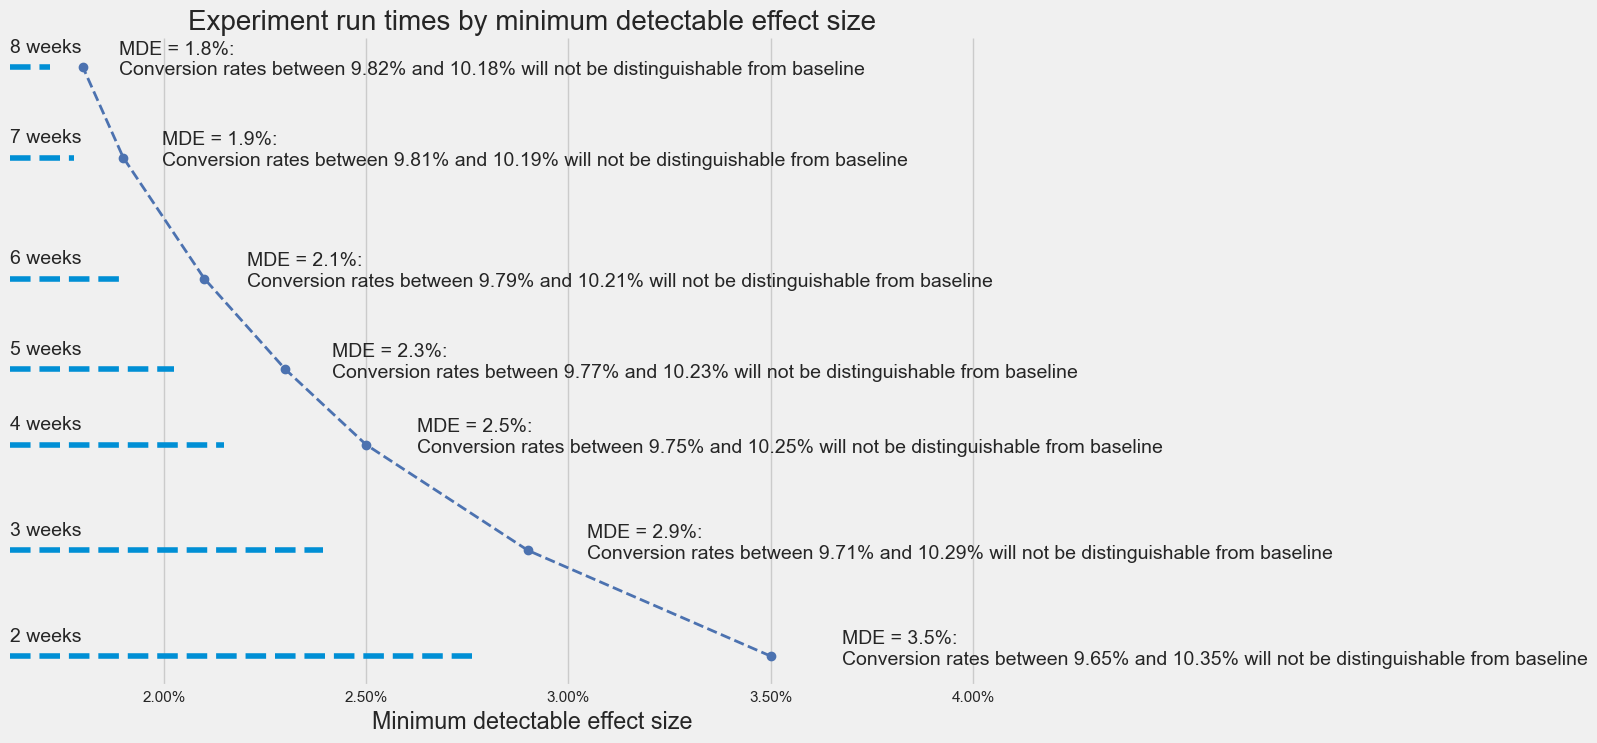

In [631]:
make_mde_plot(df_=df_mde, min_weeks=2, max_weeks=8)

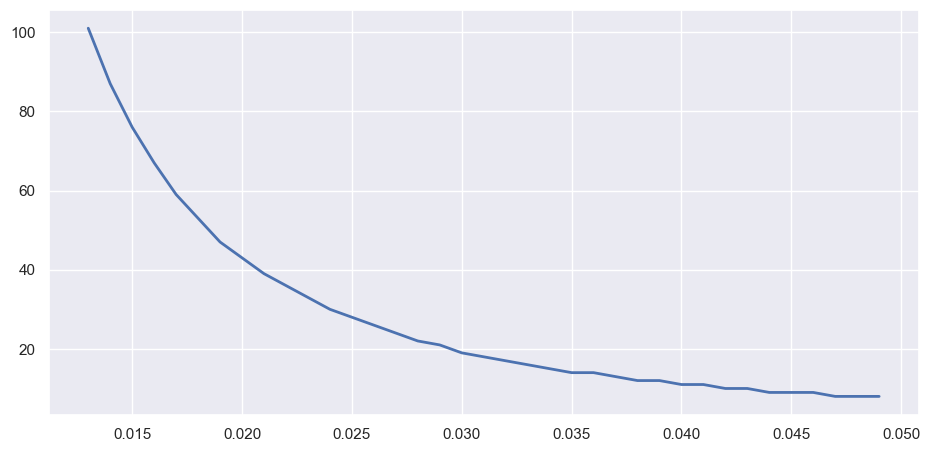

In [52]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot("mde", "days", data=df_mde.loc[(df_mde['weeks'] >= 2) & (df_mde['weeks'] <= 16)], linewidth=2, solid_capstyle="round")

In [258]:
def plot_mde_marker(df, weeks, ax):
    days = weeks * 7
    ax.axhline(
        y=days,
        linestyle="--",
        xmax=(df[df["weeks"] <= weeks]["mde"].min() - ax.get_xlim()[0])
        / ax.get_xlim()[1]
        - 0.01,
    )
    if weeks > 1:
        week_text = "weeks"
    else:
        week_text = "week"
    ax.text(
        ax.get_xlim()[0],
        days + 1,
        f"{weeks} {week_text}",
        horizontalalignment="left",
        # **roboto,
    )

    try:
        isLess = df["weeks"] <= weeks
        mde_text = "MDE = {:.2%}, Monthly value = £{:,.0f}".format(
            df[isLess]["mde"].min(), df[isLess]["Extra revenue (monthly)"].min()
        )
    except KeyError:
        mde_text = f"MDE = {df[isLess]['mde'].min():.2%}"

    ax.text(
        df[df["weeks"] <= weeks]["mde"].min() * 1.05,
        days - 0.5,
        mde_text,
        horizontalalignment="left",
        # **roboto,
    )


def y_format(x, pos):
    return f"{int(x):,}"


def mde_plot(data):
    fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
    ax.plot(
        "mde", "days", data=data, linewidth=2, solid_capstyle="round", color="#014d64"
    )

    # Formatting the tick labels

    ax.yaxis.set_major_formatter(mtick.FuncFormatter(y_format))
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    # Formatting the axes labels
    ax.set_xlabel("Minimum detectable effect") #**roboto)
    ax.set_ylabel("")

    # Set limit to reasonable amount of time
    if ax.get_ylim()[1] > 60:
        ax.set_ylim([0, 7 * max_runtime * 1.2])

    # Set x-lim
    x_limit = data[data["weeks"] <= 2]["mde"].min() * 1.2
    ax.set_xlim([0, x_limit])

    for week in range(2, max_runtime + 1):
        plot_mde_marker(data, week, ax)

    # Clean up layout of graph, removing borders
    ax.yaxis.grid(True)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Hiding the y-axis
    ax.axes.get_yaxis().set_visible(False)

    # st.write(fig)

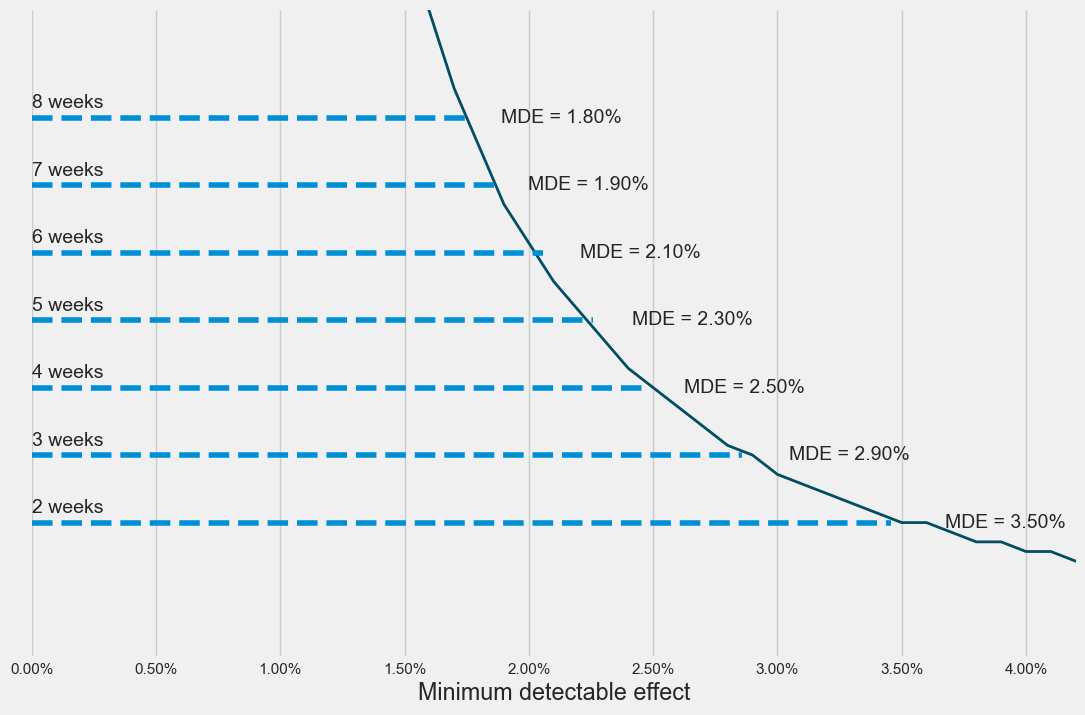

In [259]:
max_runtime = 8
mde_plot(df_mde.query('weeks >= 2'))

In [632]:
df_test_exp = create_mde_table(monthly_num_obs=30000, baseline_conversion_rate=0.238, n_variants=2, alpha=0.05, power=0.8)

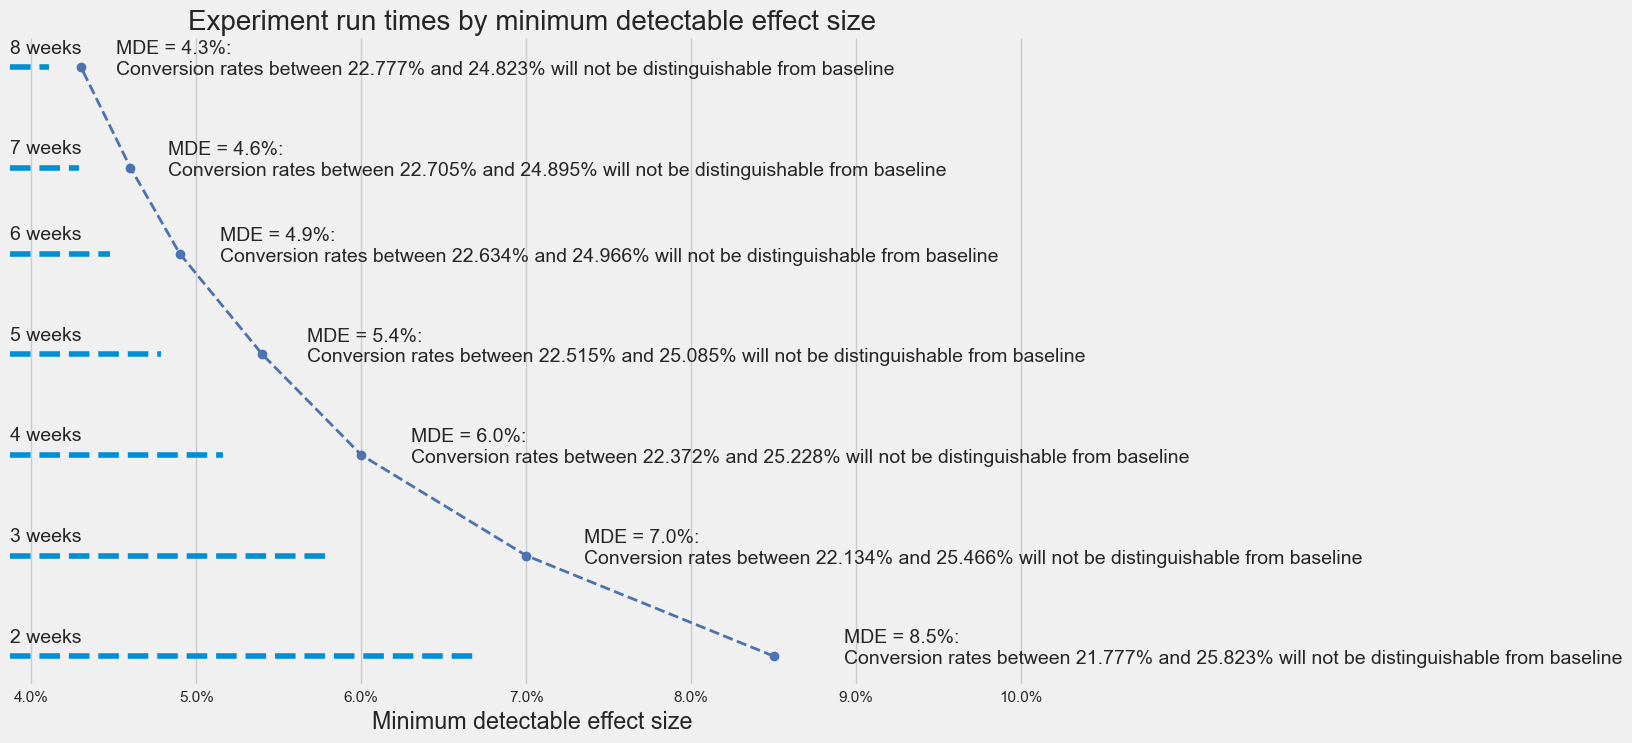

In [633]:
make_mde_plot(df_=df_test_exp, min_weeks=2, max_weeks=8)

In [635]:
df_test_exp.query("weeks==2")

,mde,new_conversion_rate_upper_bound,new_conversion_rate_lower_bound,total_sample_size,sample_size_per_variant,days,weeks,monthly_additional_conversions_upper,monthly_additional_conversions_lower
84,0.085,0.258230,0.217770,13912,6956,14,2,607,-607
85,0.086,0.258468,0.217532,13590,6795,14,2,614,-614
86,0.087,0.258706,0.217294,13280,6640,14,2,621,-621
87,0.088,0.258944,0.217056,12980,6490,13,2,628,-628
88,0.089,0.259182,0.216818,12690,6345,13,2,635,-635
89,0.090,0.259420,0.216580,12410,6205,13,2,643,-643
90,0.091,0.259658,0.216342,12138,6069,13,2,650,-650
91,0.092,0.259896,0.216104,11876,5938,12,2,657,-657
92,0.093,0.260134,0.215866,11622,5811,12,2,664,-664
93,0.094,0.260372,0.215628,11376,5688,12,2,671,-671
